 # Kaggle Competetion (House Prices: Advanced Regression Techniques)
 
## 1. Key words
* Stacking
* Model interpretation and diagnose through H2O and Skater
 
 
 
## 2. Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Competition link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
 
This notebook will cover the basic code to generate the submission file for my Kaggle competition. To have a comprehensive data exploration, please visit https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python.

Some of the following contents are from Kaggle Kernels (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels), which is a really friendly community and lots of competitors share their works here. 

## 3. Work Flow
   1. Import packages and files
   2. Data cleaning and manipulation
 * impute missing value
 * skewness
 * encoding
   3. Build predictive model
   4. Model interpretation and diagnose
 * global surrogate model
 * feature importance
 * partial dependence plot
 
## 4. Code and markdown


### (1) Import packages and files

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew 

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### (2) Data cleaning and manipulation

In [3]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


#### Data cleaning: remove outlier

There are two outliers in bottom right, suggesting there are two houses with largest above grade (ground) living area square feet having low sale prices, which is not common in the real world. Also, many works in Kaggle Kernels have shown that removing the two outliers in bottom right can improve the result.

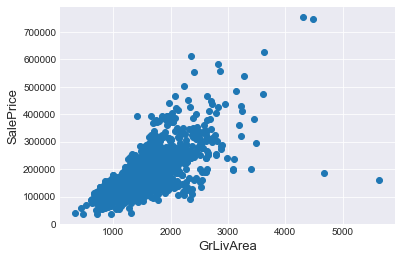

In [4]:
#Check the outlier
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

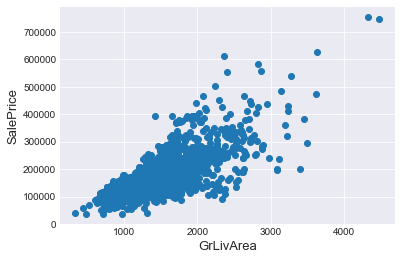

In [5]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [6]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [7]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.000,0.000,...,WD,0,Pave,8,856.000,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.000,0.000,...,WD,0,Pave,6,1262.000,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.000,0.000,...,WD,0,Pave,6,920.000,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.000,0.000,...,WD,0,Pave,7,756.000,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.000,0.000,...,WD,0,Pave,9,1145.000,AllPub,192,2000,2000,2008


In [8]:
all_data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2917.000,2917.000,2917.000,2917.000,2916.000,2916.000,2915.000,2915.000,2916.000,2917.000,...,2917.000,2917.000,2917.000,2917.000,2917.000,2916.000,2917.000,2917.000,2917.000,2917.000
mean,1157.692,335.862,2.604,2.860,439.015,49.616,0.429,0.061,560.696,23.114,...,5.565,6.086,2.089,16.073,6.448,1049.328,93.629,1971.288,1984.248,2007.793
std,385.264,428.120,25.197,0.823,444.182,169.259,0.524,0.246,439.652,64.263,...,1.113,1.407,34.561,56.202,1.564,429.106,126.533,30.287,20.892,1.315
min,334.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,0.000,2.000,0.000,0.000,1872.000,1950.000,2006.000
25%,876.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,220.000,0.000,...,5.000,5.000,0.000,0.000,5.000,793.000,0.000,1953.000,1965.000,2007.000
50%,1082.000,0.000,0.000,3.000,368.000,0.000,0.000,0.000,467.000,0.000,...,5.000,6.000,0.000,0.000,6.000,988.500,0.000,1973.000,1993.000,2008.000
75%,1384.000,704.000,0.000,3.000,733.000,0.000,1.000,0.000,804.500,0.000,...,6.000,7.000,0.000,0.000,7.000,1302.000,168.000,2001.000,2004.000,2009.000
max,5095.000,2065.000,508.000,8.000,4010.000,1526.000,3.000,2.000,2336.000,1012.000,...,9.000,10.000,800.000,576.000,15.000,5095.000,1424.000,2010.000,2010.000,2010.000


#### Data cleaning: impute missing values

In [9]:
# check which columns have missing values
all_data.isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            2719
BedroomAbvGr        0
BldgType            0
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       80
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         1
Exterior2nd         1
Fence            2346
FireplaceQu      1420
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LotFrontage       486
LotShape            0
LowQualFinSF        0
MSSubClass          0
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2812
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


In [11]:
#Check the classes in PoolQC
all_data['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

Although there are lots of missing values in 'PoolQC', we can see there is no 'None' option for those houses with no pool. Therefore, let's impute the missing values as 'None'. And we do the same thing for several other features.

For categorical variables, we impute missing values with the modes.

For continuous variables, impute missing values with the medians.

In [12]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
all_data = all_data.drop(['Utilities'], axis=1)
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


In [13]:
all_data.isnull().sum().sum()

0

#### Data manipulation: skewness

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 12.02 and sigma = 0.40



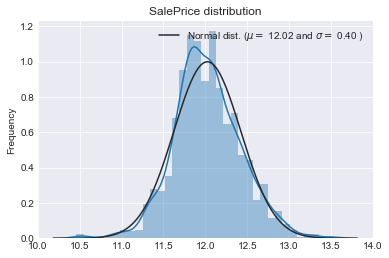

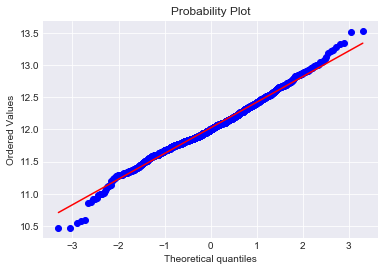

In [14]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)

#Check the new distribution 
sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

In [15]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945
BsmtHalfBath,3.930


In [16]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 33 skewed numerical features to Box Cox transform


#### Data manipulation: encoding

Apply label encoding to ordinal variables and one hot encoding to nominal variables. Here we introduced some bias because we didn't carefully label all ordinal variables, and there were also some leakages because we applied one hot encoding before the data partition. In future work we can try other methods like target encoding within pipeline.

In [17]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


In [18]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [19]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.693,11.686,0.000,1,1.541,4,3,11.170,0.000,2,...,0,0,0,0,0,0,0,0,0,1
1,12.792,0.000,0.000,1,1.541,4,1,12.063,0.000,0,...,0,0,0,0,0,0,0,0,0,1
2,11.892,11.725,0.000,1,1.541,4,2,10.200,0.000,2,...,0,0,0,0,0,0,0,0,0,1
3,12.014,11.354,0.000,1,1.541,1,3,8.274,0.000,0,...,0,0,0,0,0,0,0,0,0,1
4,12.511,12.271,0.000,1,1.820,4,0,10.971,0.000,2,...,0,0,0,0,0,0,0,0,0,1


In [20]:
all_data.isnull().sum().sum()

0

In [21]:
train = all_data[:ntrain]
test = all_data[ntrain:]

### (3) Build predictive model

In [22]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import lightgbm as lgb

In [23]:
# set the number of folds for cross validation
n_folds = 10

Initiate classifiers. At the first time we should search the hyper parameters using grid search or randomized search. For convinience, we apply the best tuned hyper parameters directly here.

In [24]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
lightgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [25]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, feat_select_model, meta_model, n_folds=n_folds):
        self.base_models = base_models
        self.feat_select_model = feat_select_model
        self.meta_models = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]   # output:[[], [], []]
        self.feat_select_model_ = []
        feat_select_model = clone(self.feat_select_model)         # don't change anything  
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156) 
        #output:KFold(n_splits=5, random_state=156, shuffle=True)
        #when we shuffle, the sequence of holdout would change, would be discret but not overlap
        #if we not shuffle, no matter what the random_state is, the holdout sequence would in order


        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        #same rows as data,same columns as models
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)+1))
        
        for train_index, holdout_index in kfold.split(X,y):
                # kfold.split(X,y) and kfold.split(X) are the same, and X , y should have same rows or range
                # split the data into 10 part, 9 part to train, 1 part to test
                # run this 10 times: output the index of train and index of test in this interation
                # this loop mean: for each cv interation (total 10):
                
            feat_select_model.fit(X[train_index], y[train_index])
            y_pred = feat_select_model.predict(X[holdout_index])
            # store the prediction for each iteration(10)
            out_of_fold_predictions[holdout_index, 0] = y_pred     
            coef = pd.Series(feat_select_model.steps[1][1].coef_)
            used_columns= coef[coef!= 0]
            each_cv_X=X[:,used_columns.index]
            self.feat_select_model_.append(feat_select_model)  
            
            for i, model in enumerate(self.base_models): 
                # create index for model, i is the model index, model is the model information
                # this loop mean: for each model:
                instance = clone(model)

                # instacne is a real model, fit the train values and response for each model for each iteration
                instance.fit(each_cv_X[train_index], y[train_index])
                y_pred = instance.predict(each_cv_X[holdout_index])
                # store the prediction for each iteration(10) and each base model(3)
                out_of_fold_predictions[holdout_index, i+1] = y_pred
                
                # earlier we create a empty list, now we append the model information in the list
                # for the first iter, for the first model, list would be [[model1_cv1], [], []]
                # for the first iter, for the second model, list would be [[model1_cv1], [model2_cv1], []] 
                # for the second iter, for the first model, list would be [[model1_cv1,model1_cv2], [model2_cv1], []]                

                pair=[instance,used_columns.index]
                # at the end, the list would have 30 instances
                self.base_models_[i].append(pair)
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        # meta_model is a real model, can use the fit function directly
        for model in self.meta_models:
            model.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, test): 
        meta_features = np.array([list() for test in range(0,len(test))])
        predictions = np.array([list() for test in range(0,len(test))])

        for instance in self.feat_select_model_ :
            prediction_1=instance.predict(test)
            predictions=np.column_stack((predictions,prediction_1))
        
        meta_feature_1=predictions.mean(axis=1)

        # self.base_models_=[[model1_cv1,...,model1_cv10], [...], [model3_cv1,...,model3_cv10]]
        for base_models in self.base_models_ :
            predictions = np.array([list() for test in range(0,len(test))])
            for instance,index in base_models:
                prediction=instance.predict(test[:,index])
                predictions=np.column_stack((predictions,prediction))
            meta_feature=predictions.mean(axis=1)
            meta_features=np.column_stack((meta_features,meta_feature))
        meta_features=np.column_stack((meta_feature_1,meta_features))

        self.meta_features=meta_features
        
        predict = np.column_stack([
            model.predict(meta_features) for model in self.meta_models
        ])
        result = np.column_stack((predict,meta_features.mean(axis=1)))
        return np.mean(result, axis=1) 
        # meta_model is a real model, can use the predict function directly

In [26]:
stacked_averaged_models = StackingAveragedModels(base_models = (KRR, GBoost, lightgb),
                                                 feat_select_model = lasso,
                                                 meta_model = (ENet,model_xgb,lasso))

In [27]:
stacked_averaged_models.fit(train.values, y_train)

StackingAveragedModels(base_models=(KernelRidge(alpha=0.6, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None), GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)),
            feat_select_model=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))]),
            meta_model=None, n_folds=10)

In [28]:
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))

In [29]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = stacked_pred
sub.to_csv('submission.csv',index=False)

This sumission allows me to get rmse 0.11428 on test set and rank top 3% on Kaggle.

### (4) Model interpretation and diagnose

We implement global interpretation techniques here to understand the complicated stacking model we created above in a general aspect. To have local interpretation for how a specific house gets its prediction, we should use Individual Conditional Expectation (ICE),Shapley values or Local Interpretable Model-agnostic Explanations (LIME). 

In [30]:
import h2o
from h2o.backend import H2OLocalServer
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

from IPython.display import Image
from IPython.display import display
import os
import re
import subprocess
from subprocess import CalledProcessError
import time
import operator

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /Users/zengweihao/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/m7/1trmx2qs6vggd9ygt9nd4dpr0000gn/T/tmpjgk7_hx4
  JVM stdout: /var/folders/m7/1trmx2qs6vggd9ygt9nd4dpr0000gn/T/tmpjgk7_hx4/h2o_zengweihao_started_from_python.out
  JVM stderr: /var/folders/m7/1trmx2qs6vggd9ygt9nd4dpr0000gn/T/tmpjgk7_hx4/h2o_zengweihao_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,11 days
H2O cluster name:,H2O_from_python_zengweihao_t613p3
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


In [31]:
train_h2o = train
y_train_pred = stacked_averaged_models.predict(train.values)
train_h2o['SalePrice'] = y_train_pred

In [32]:
traindf = h2o.H2OFrame(train_h2o)
y = 'SalePrice'
X = [name for name in traindf.columns if name not in y]

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Global interpretation: Global surrogate model

In [33]:
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,          # use only one tree
                                         sample_rate=1,     # use all rows in that tree
                                         col_sample_rate=1, # use all columns in that tree
                                         max_depth=3,       # shallow trees are easier to understand
                                         seed=12345,        # random seed for reproducibility
                                         model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y=y, training_frame=traindf)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /Users/zengweihao/Desktop/study/practicum/dt_surrogate_mojo.zip


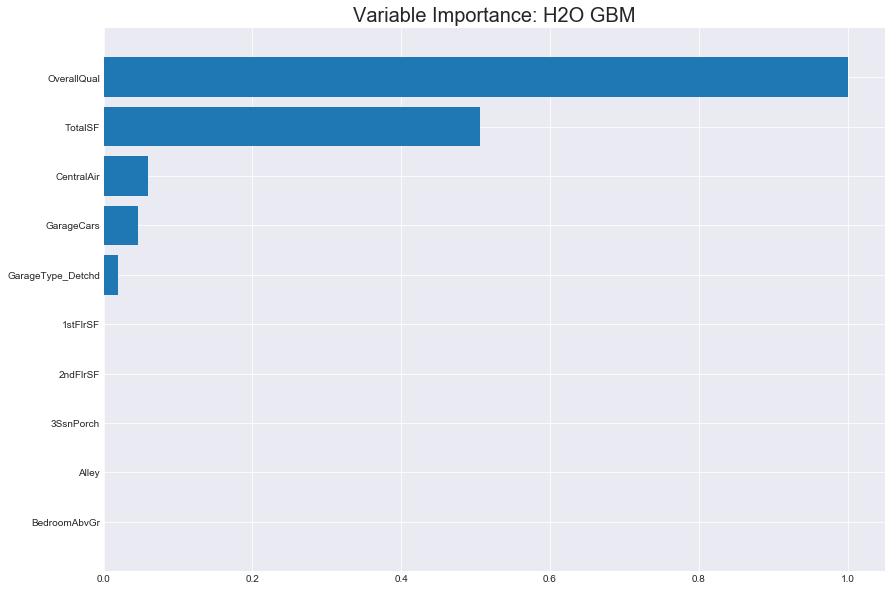

In [34]:
surrogate.varimp_plot()

In [35]:
details = False # print more info on tree, details = True
title = 'Home Prices Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /Users/zengweihao/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/zengweihao/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/zengweihao/Desktop/study/practicum/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Home Prices Decision Tree Surrogate


In [36]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


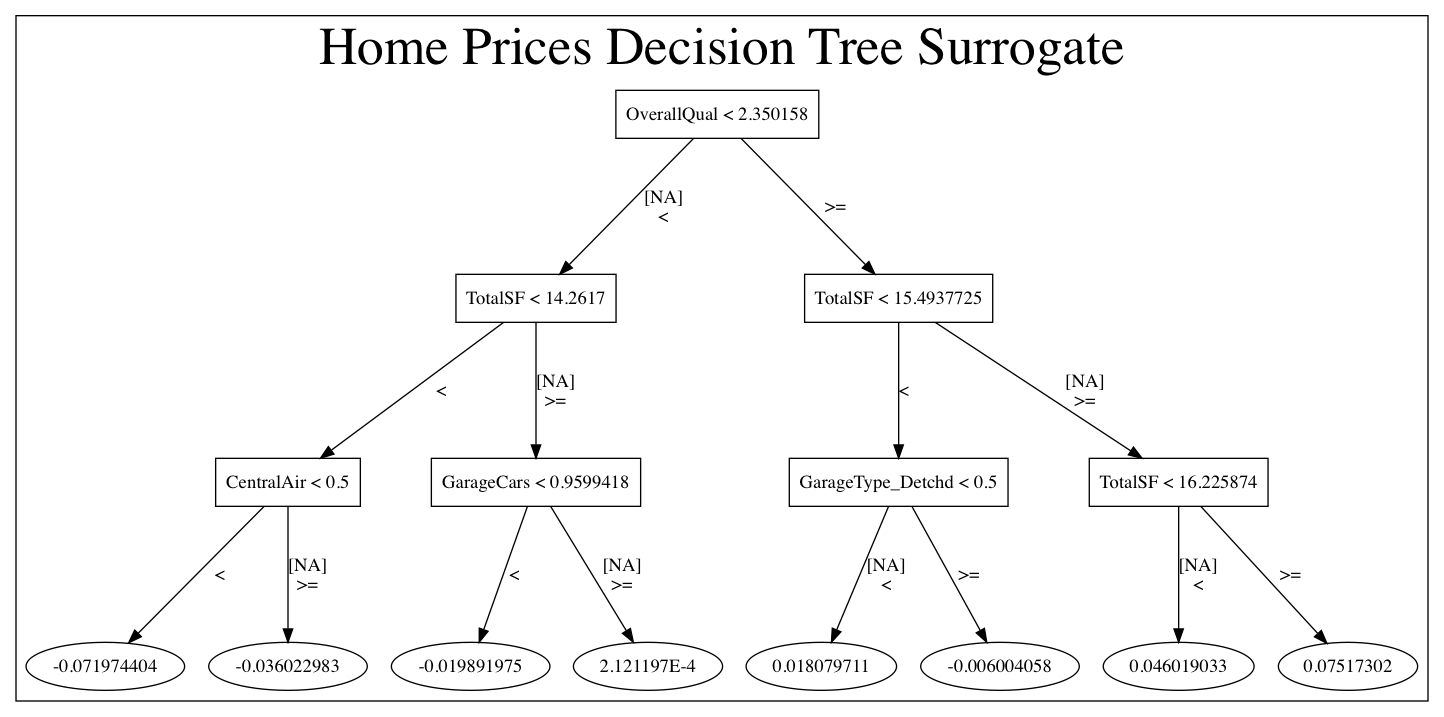

In [37]:
display(Image((png_file_name)))

To have a intuitive visualized presentation from the single decision tree model, we set max depth = 3 to surrogate the stacking machine learning model. However, we have very few variables and interactions in the single decision tree model, making this tree surrogate model have a poor performance. Then let's see how a linear model will perform in the model surrogation.

In [38]:
# initialize
glm = H2OGeneralizedLinearEstimator(lambda_search=True)

# train 
glm.train(x=X, y=y, training_frame=traindf)

#show information
print(glm)

# coefs
print('\nGLM Stadardized Coefficients:')
for c_name, c_val in sorted(glm.coef_norm().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nGLM R-square:\n%.2f' % glm.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1546984856427_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.001999676686206897
RMSE: 0.04471774464579913
MAE: 0.033046547944336285
RMSLE: 0.0034471516108440107
R^2: 0.9866607148413433
Mean Residual Deviance: 0.001999676686206897
Null degrees of freedom: 1457
Residual degrees of freedom: 1380
Null deviance: 218.56708015537606
Residual deviance: 2.9155286084896557
AIC: -4765.509559482877
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2019-01-08 17:01:03,0.000 sec,1,.66E0,1,0.1499088,nan
,2019-01-08 17:01:03,0.025 sec,2,.63E0,3,0.1419991,nan
,2019-01-08 17:01:03,0.035 sec,3,.6E0,3,0.1329669,nan
,2019-01-08 17:01:03,0.046 sec,4,.57E0,3,0.1245587,nan
,2019-01-08 17:01:03,0.051 sec,5,.55E0,3,0.1167394,nan
---,---,---,---,---,---,---,---
,2019-01-08 17:01:04,0.389 sec,96,.79E-2,68,0.0021911,nan
,2019-01-08 17:01:04,0.396 sec,97,.76E-2,70,0.0021396,nan
,2019-01-08 17:01:04,0.403 sec,98,.72E-2,74,0.0020912,nan
,2019-01-08 17:01:04,0.408 sec,99,.69E-2,75,0.0020454,nan



See the whole table with table.as_data_frame()


GLM Stadardized Coefficients:
KitchenQual:              -0.02044475474216629
ExterQual:                -0.018835324337010677
BsmtQual:                 -0.01713119370688469
MSZoning_C (all):         -0.01547614646963132
SaleCondition_Abnorml:    -0.01377152479790819
MSZoning_RM:              -0.0117484040517274
HeatingQC:                -0.009311353889478572
BsmtUnfSF:                -0.008133688460533434
KitchenAbvGr:             -0.008047890182958354
BsmtExposure:             -0.005565839104779436
Neighborhood_Edwards:     -0.003938417229706795
GarageFinish:             -0.0035217546717253257
Condition1_Artery:        -0.0030426366224419305
Heating_Grav:             -0.002646347935190294
Foundation_BrkTil:        -0.0024655050146842206
SaleCondition_Family:     -0.001344183244557116
Neighborhood_NWAmes:      -0.0012666182693444326
MasVnrType_BrkCmn:        -0.0011402188209904632
Exterior1st_Wd Sdng:      -0.0010988261016975757
GarageTy

The linear surrogate model did pretty well, it can simulate the prediction from the black box machine learning model accurately. Also, from the standardized coefficients, we can find out which variables (GarageCars, OverallCond, LotArea, YearBuilt, OverallQual, GrLivArea, TotalSF) are important based on the magnitude. 

Besides, these well estimated coefficients help us diagnose our machine learning process. We can see the kitchen quality, external quality and basement quality have a negative effect on the sale price, which doesn't make sense. It could be because we simply perform label encoding on these ordinal variables in the data mainpulation process earlier, without carefully assigning a larger number to higher quality.

#### Global interpretation: Feature importance

Since the linear surrogation model perform pretty well, we can estimate the feature importance based on the magnitude of the coefficients. In other cases (e.g., we want to get the feature importance directly from the model, we can use the following code:

In [39]:
#interpreter = Interpretation(training_data=train.values, training_labels=y_train, 
#                             feature_names=list(train.columns))
#im_model = InMemoryModel(stacked_models.predict, examples=train.values)
#interpreter.feature_importance.plot_feature_importance(im_model, ascending=True,progressbar=True)

#### Global interpretation: Partial Dependence Plot

In [40]:
# Remove the target, 'SalePrice' from the training set
train=train.iloc[:,:-1]
train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.693,11.686,0.000,1,1.541,4,3,11.170,0.000,2,...,0,0,0,0,0,0,0,0,0,1
1,12.792,0.000,0.000,1,1.541,4,1,12.063,0.000,0,...,0,0,0,0,0,0,0,0,0,1
2,11.892,11.725,0.000,1,1.541,4,2,10.200,0.000,2,...,0,0,0,0,0,0,0,0,0,1
3,12.014,11.354,0.000,1,1.541,1,3,8.274,0.000,0,...,0,0,0,0,0,0,0,0,0,1
4,12.511,12.271,0.000,1,1.820,4,0,10.971,0.000,2,...,0,0,0,0,0,0,0,0,0,1


It seems the Light GBM is not compatible with the current Skater package. Based on the above linear surrogation, we can see non linearity doesn't contribute too much on the prediction (but it helps improve the score on Kaggle). So we remove the light gbm from the stacking model, to have a appoximate insight from the original black box stacking model.

In [41]:
stacked_models = StackingAveragedModels(base_models = (KRR, GBoost),
                                        feat_select_model = lasso,
                                        meta_model = (ENet,model_xgb,lasso))

In [42]:
stacked_models.fit(train.values,y_train)

StackingAveragedModels(base_models=(KernelRidge(alpha=0.6, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None), GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=...      subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)),
            feat_select_model=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))]),
            meta_model=None, n_folds=10)

[[<Figure size 1152x720 with 1 Axes>,
 [<Figure size 1152x720 with 1 Axes>,

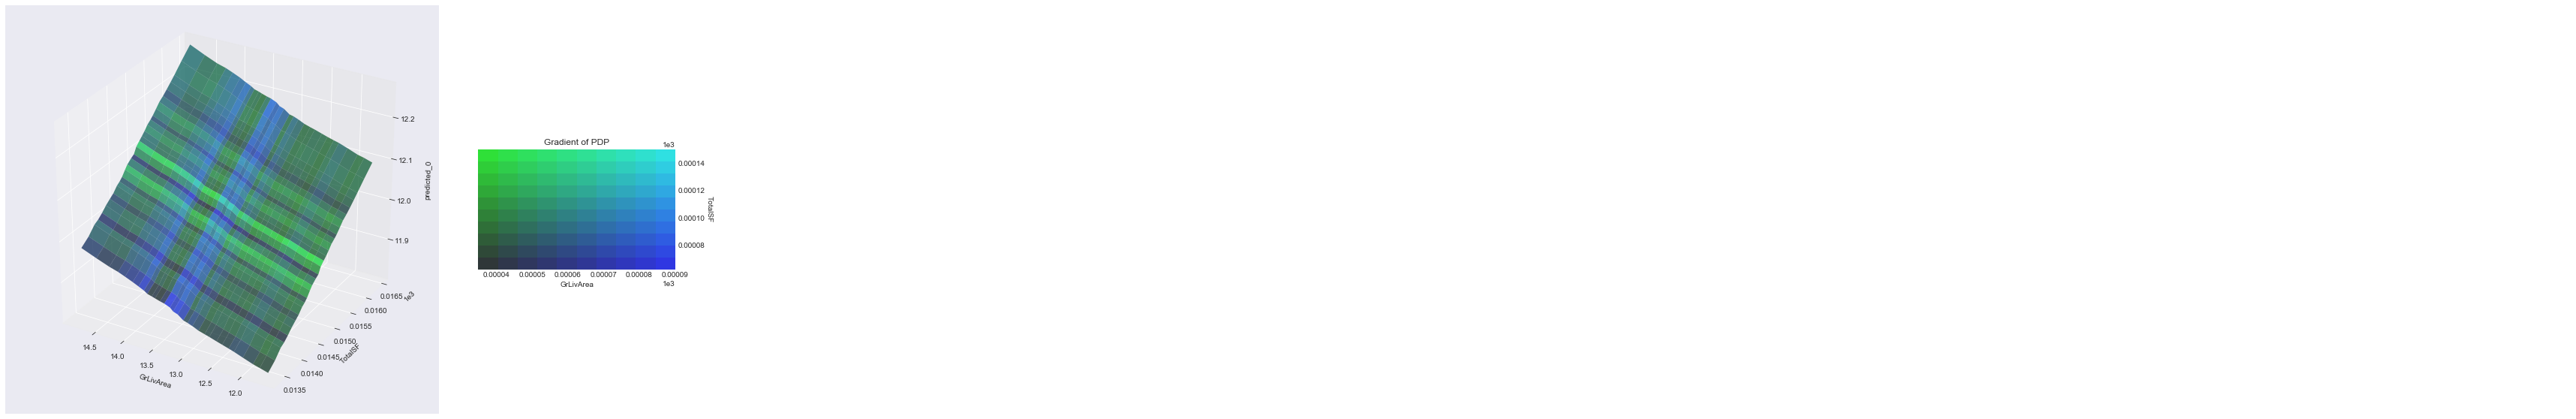

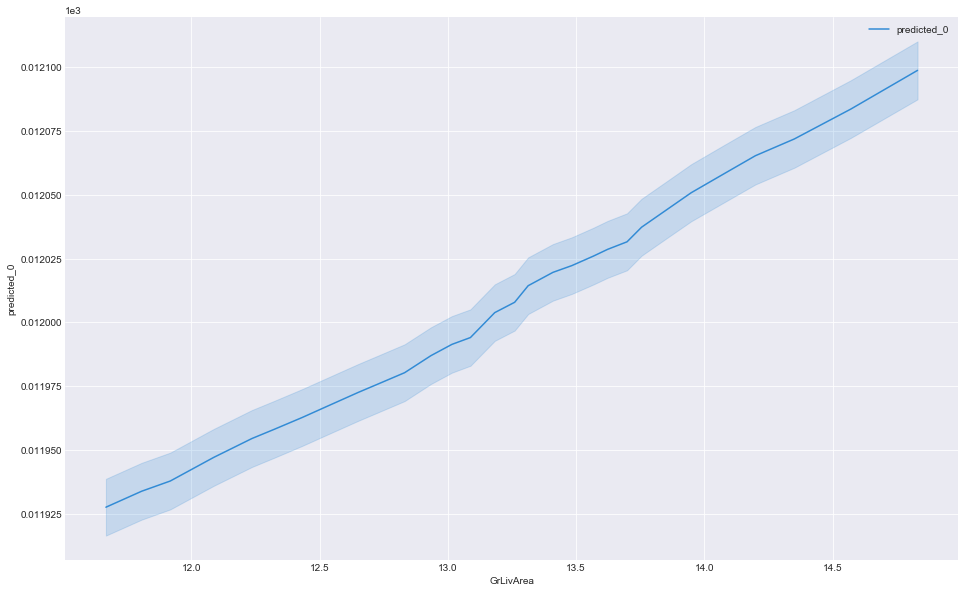

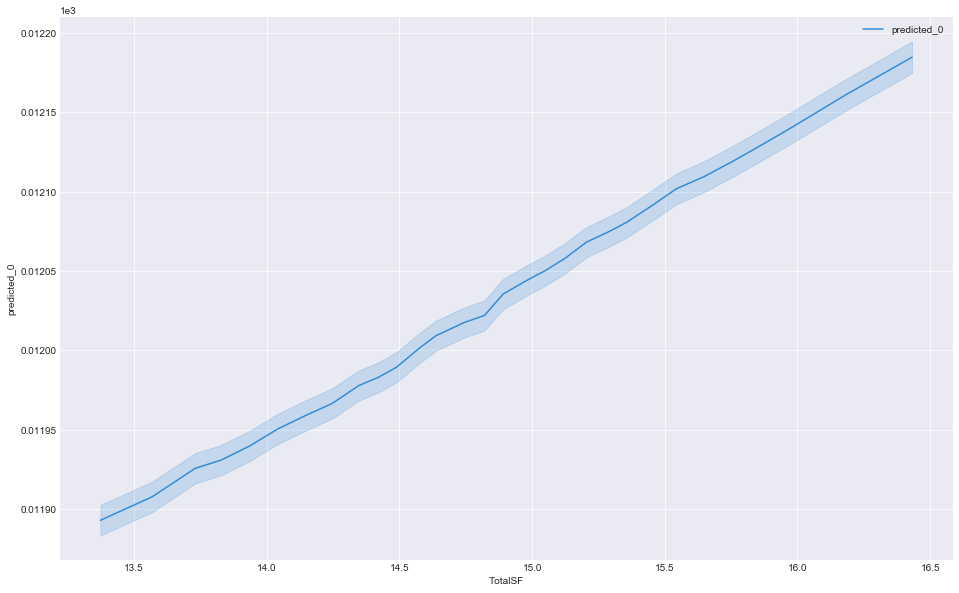

In [43]:
interpreter = Interpretation(training_data=train.values, training_labels=y_train, 
                             feature_names=list(train.columns))
im_model = InMemoryModel(stacked_models.predict, examples=train.values)

# Features can passed as a tuple for 2-way partial plot
pdp_features = [('GrLivArea', 'TotalSF')]
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, im_model, grid_resolution=30,progressbar=False)

# or as independent features for 1-way partial plots
pdp_features = ['GrLivArea', 'TotalSF']
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, im_model, grid_resolution=30,with_variance=True,progressbar=False)

We can find there is a monotonic increasing relationship between TotalSF(after handling skewness) and SalePrice(after log tranformation), which is similar between GrLivArea(after handling skewness) and SalePrice(after log tranformation). Both of them are making good sense.

In [44]:
# shutdown h2o
h2o.cluster().shutdown(prompt=False)

H2O session _sid_9363 closed.
